In [1]:
import fs
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OrdinalEncoder

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from joblib import dump
from joblib import load
from sklearn.model_selection import cross_val_score

import optuna
from sklearn.model_selection import StratifiedKFold

In [2]:
PROCESSED_PROJECT_DIR = fs.open_fs("../../data/processed/project")
TRAIN_FILE_NAME = PROCESSED_PROJECT_DIR.getsyspath("train.csv")
TEST_FILE_NAME = PROCESSED_PROJECT_DIR.getsyspath("test.csv")

MODEL_PROJECT_DIR = fs.open_fs("../../models/project")
MODEL_FILE_NAME = MODEL_PROJECT_DIR.getsyspath("pipeline_model.joblib")

## Balanced with all variables

### Training

In [3]:
train_df = pd.read_csv(TRAIN_FILE_NAME)

In [4]:
categoric_features = ['BAD', 'REASON', 'JOB']
train_df[categoric_features] = train_df[categoric_features].apply(lambda col: col.astype('category'))
numeric_features = train_df.select_dtypes(include=['int', 'float']).columns.tolist()
categoric_features = ['REASON', 'JOB']

In [5]:
# Submuestrear la clase mayoritaria (0)
df_majority = train_df[train_df['BAD'] == 0].sample(n=588, random_state=11)
df_minority = train_df[train_df['BAD'] == 1]

# Concatenar ambas muestras
train_df = pd.concat([df_majority, df_minority])

In [6]:
train_df['BAD'].value_counts()

BAD
0    588
1    588
Name: count, dtype: int64

In [7]:
X_train = train_df.drop(columns=['BAD'])
y_train = train_df['BAD']

In [8]:
model = XGBClassifier()

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OrdinalEncoder(), categoric_features)
    ])

In [10]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', model)])

In [11]:
model_to_val = pipeline.fit(X_train, y_train)
dump(pipeline, MODEL_FILE_NAME)

['/Users/miguelsepulveda/Library/CloudStorage/OneDrive-Personal/MacBook/UP/MCD/Materias/ML II/MCD-ML2/models/project/pipeline_model.joblib']

In [12]:
model_to_val = load(MODEL_FILE_NAME)
preds_train = model_to_val.predict(X_train)

In [13]:
acc_train = metrics.accuracy_score(y_train, preds_train)
pred_p = model.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, pred_p[:, 1])
auc_train = metrics.auc(fpr, tpr)
f1_train = metrics.f1_score(y_train, preds_train)
recall_train = metrics.recall_score(y_train, preds_train)
prcson_train = metrics.precision_score(y_train, preds_train)

In [14]:
#ALL
print(f"accuracy_train:{acc_train}")
print(f"auc_train:{auc_train}")
print(f"f1_score_train:{f1_train}")
print(f"recall_train:{recall_train}")
print(f"precision_train:{prcson_train}")
print(classification_report(y_train, preds_train))

accuracy_train:1.0
auc_train:0.3653570271646074
f1_score_train:1.0
recall_train:1.0
precision_train:1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       588
           1       1.00      1.00      1.00       588

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176



In [15]:
#FEW
print(f"accuracy_train:{acc_train}")
print(f"auc_train:{auc_train}")
print(f"f1_score_train:{f1_train}")
print(f"recall_train:{recall_train}")
print(f"precision_train:{prcson_train}")
print(classification_report(y_train, preds_train))

accuracy_train:1.0
auc_train:0.3653570271646074
f1_score_train:1.0
recall_train:1.0
precision_train:1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       588
           1       1.00      1.00      1.00       588

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176



In [16]:
conf_matrix_train = metrics.confusion_matrix(y_train, preds_train)

In [17]:
conf_matrix_train

array([[588,   0],
       [  0, 588]])

### Testing

In [18]:
test_df = pd.read_csv(TEST_FILE_NAME)

In [19]:
categoric_features = ['BAD', 'REASON', 'JOB']
test_df[categoric_features] = test_df[categoric_features].apply(lambda col: col.astype('category'))
numeric_features = test_df.select_dtypes(include=['int', 'float']).columns.tolist()
X_test = test_df.drop(columns=['BAD'])
y_test = test_df['BAD']

In [20]:
# Cargar el pipeline guardado
loaded_pipeline = load(MODEL_FILE_NAME)

# Usar el pipeline cargado para predecir
predictions = loaded_pipeline.predict(X_test)

In [21]:
acc_test = metrics.accuracy_score(y_test, predictions)
pred_ptest = loaded_pipeline.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_ptest[:, 1])
auc_test = metrics.auc(fpr, tpr)
f1_test = metrics.f1_score(y_test, predictions)
recall_test = metrics.recall_score(y_test, predictions)
prcson_test = metrics.precision_score(y_test, predictions)

In [22]:
#ALL
print(f"accuracy_train:{acc_test}")
print(f"auc_train:{auc_test}")
print(f"f1_score_train:{f1_test}")
print(f"recall_train:{recall_test}")
print(f"precision_train:{prcson_test}")
print(classification_report(y_test, predictions))

accuracy_train:0.8505526189332052
auc_train:0.9171977973404969
f1_score_train:0.6959921798631477
recall_train:0.8416075650118203
precision_train:0.5933333333333334
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1658
           1       0.59      0.84      0.70       423

    accuracy                           0.85      2081
   macro avg       0.77      0.85      0.80      2081
weighted avg       0.88      0.85      0.86      2081



In [23]:
conf_matrix_test = metrics.confusion_matrix(y_test, predictions)
conf_matrix_test

array([[1414,  244],
       [  67,  356]])

In [24]:
#FEW
print(f"accuracy_train:{acc_test}")
print(f"auc_train:{auc_test}")
print(f"f1_score_train:{f1_test}")
print(f"recall_train:{recall_test}")
print(f"precision_train:{prcson_test}")
print(classification_report(y_test, predictions))

accuracy_train:0.8505526189332052
auc_train:0.9171977973404969
f1_score_train:0.6959921798631477
recall_train:0.8416075650118203
precision_train:0.5933333333333334
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1658
           1       0.59      0.84      0.70       423

    accuracy                           0.85      2081
   macro avg       0.77      0.85      0.80      2081
weighted avg       0.88      0.85      0.86      2081



In [25]:
conf_matrix_test = metrics.confusion_matrix(y_test, predictions)
conf_matrix_test

array([[1414,  244],
       [  67,  356]])

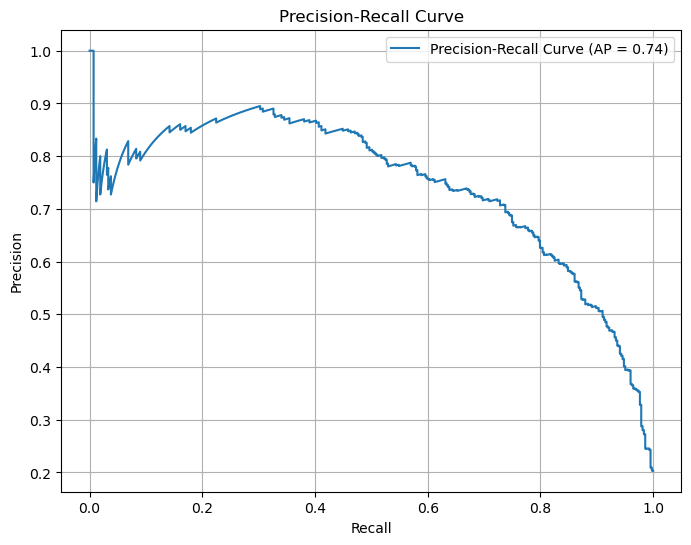

In [26]:
# FEW
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Suponiendo que tienes X_test y y_test
# Obtener las probabilidades de la clase positiva
y_scores = loaded_pipeline.predict_proba(X_test)[:, 1]  # Asegúrate de usar el modelo que hayas entrenado

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calcular el promedio de la precisión
average_precision = average_precision_score(y_test, y_scores)

# Graficar la curva de precisión-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()


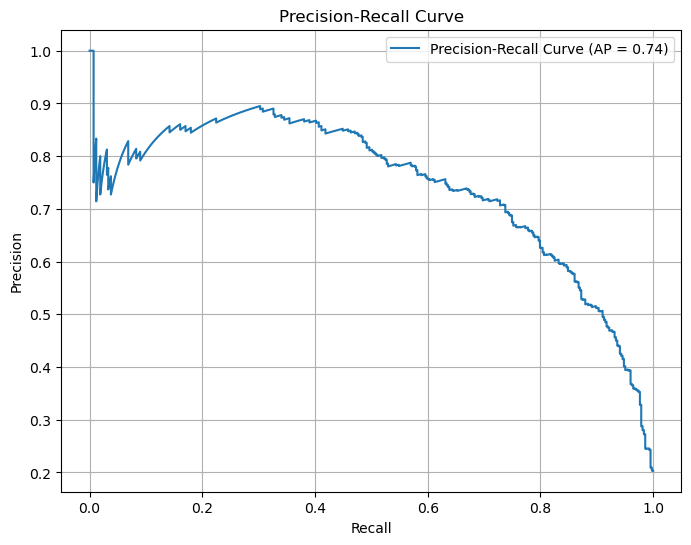

In [27]:
# ALL
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Suponiendo que tienes X_test y y_test
# Obtener las probabilidades de la clase positiva
y_scores = pipeline.predict_proba(X_test)[:, 1]  # Asegúrate de usar el modelo que hayas entrenado

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calcular el promedio de la precisión
average_precision = average_precision_score(y_test, y_scores)

# Graficar la curva de precisión-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()